In [1]:
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

import mitequinox.utils as ut
import mitequinox.plot as pl

In [2]:
if False:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(walltime='06:00:00')
    w = cluster.scale(jobs=20)
    client = Client(cluster)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38033 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


## Store

In [ ]:
# same but over all variables and faces
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
#V = V+["KPPhbl", "qsoceTAUX", "oceTAUY"]

In [ ]:
def compute_store(v, ds, diag, op):
    #i, j = ut.get_ij_dims(ds)
    diag_zarr = diag+"_"+v
    if not ut.is_diagnostic(diag_zarr):
        out, tmp_zarr = ut.custom_distribute(ds, op, 
                                             tmp_dir=ut.scratch+"tmp/", 
                                             face=1, ) # **{j: 1080}
        ut.store_diagnostic(diag_zarr, out, overwrite=True)
        print("{} {} stored".format(v, diag))
    else:
        print("{} {} already exists".format(v, diag))

In [ ]:
diags = {"mean": lambda x: x.mean("time"),
         "mean_square": lambda x: (x**2).mean("time"),
        }
        
for v in V:
    ds = ut.load_data(v)
    for diag, op in diags.items():
        compute_store(v, ds, diag, op)

# Read results

In [33]:

# load diagnostics
V = ["SSU", "SSV",]
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
D = ["mean", "mean_square"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])
ds

<xarray.Dataset>
Dimensions:          (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates:
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                (i) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j                (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * i_g              (i_g) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j_g              (j_g) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
Data variables:
    mean_Eta         (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_square_Eta  (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_SSU         (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_square_SSU  (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_SSV         (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_square_SSV  (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_SST         (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_square_SST  (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_SSS         (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_square_SSS  (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

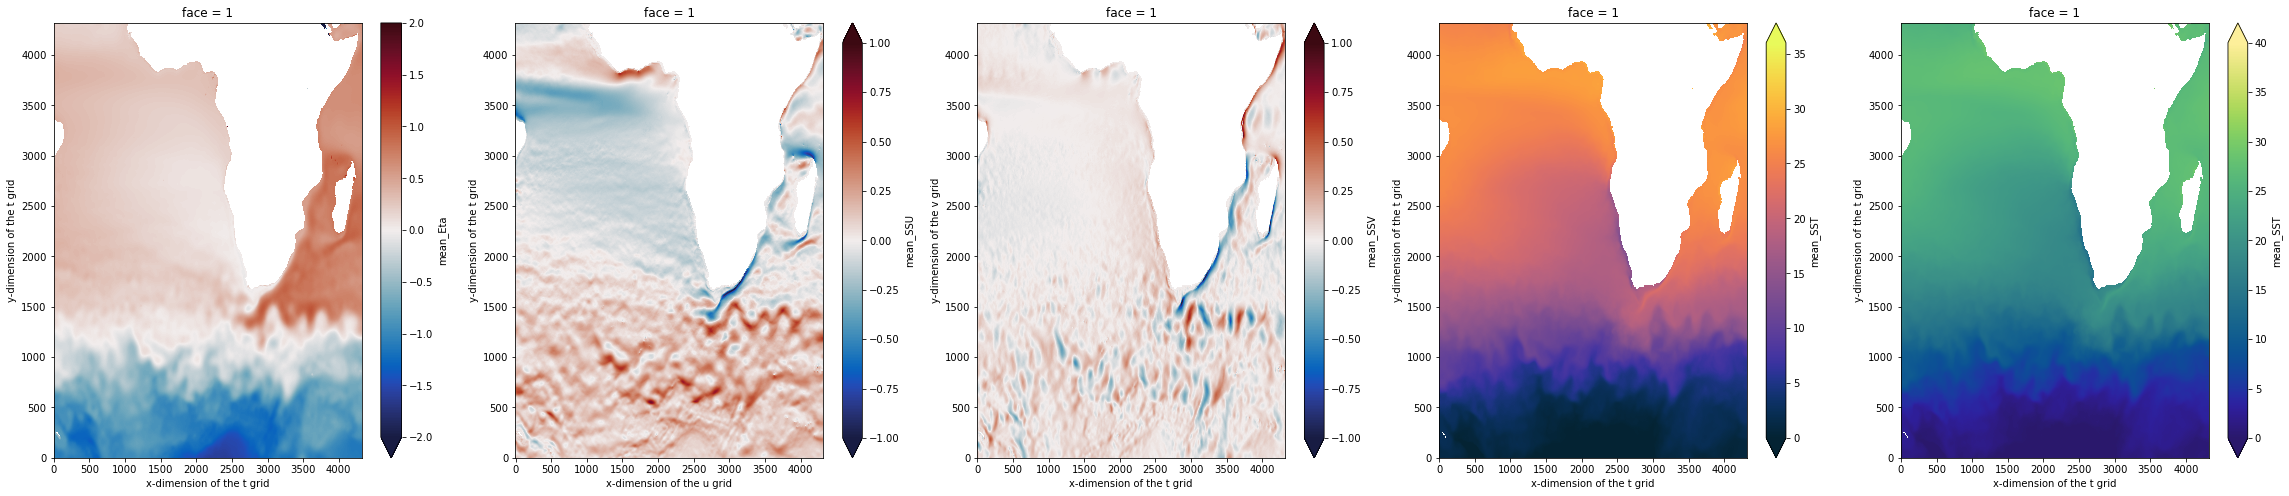

In [44]:
fig, ax = plt.subplots(figsize=(40,8))

ax = plt.subplot(151)
ds.mean_Eta.isel(face=1).plot(vmin=-2,vmax=2,cmap=cm.balance)

ax = plt.subplot(152)
ds.mean_SSU.isel(face=1).plot(vmin=-1,vmax=1,cmap=cm.balance)

ax = plt.subplot(153)
ds.mean_SSV.isel(face=1).plot(vmin=-1,vmax=1,cmap=cm.balance)

ax = plt.subplot(154)
ds.mean_SST.isel(face=1).plot(vmin=0,vmax=36,cmap=cm.thermal)

ax = plt.subplot(155)
ds.mean_SST.isel(face=1).plot(vmin=0,vmax=40,cmap=cm.haline)

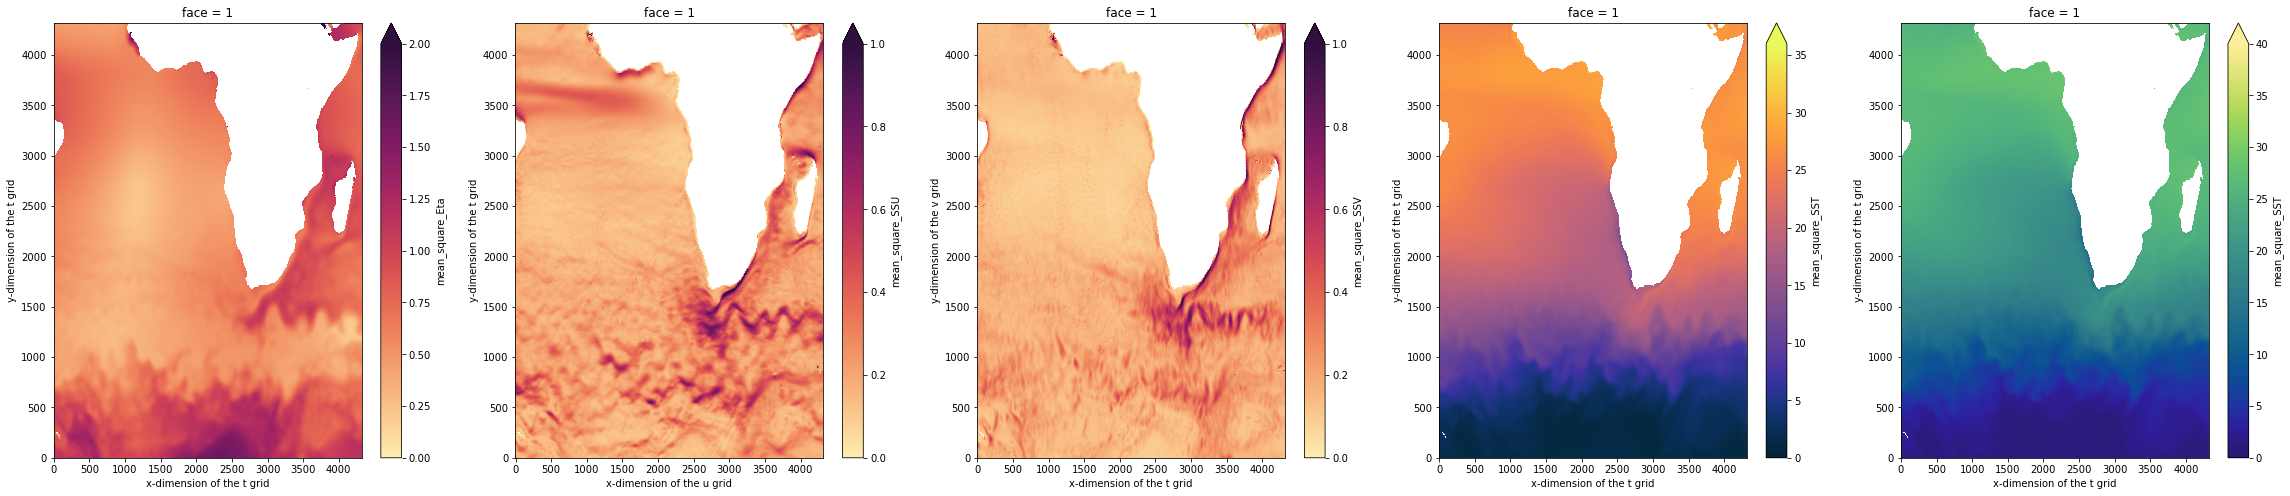

In [45]:
fig, ax = plt.subplots(figsize=(40,8))

ax = plt.subplot(151)
np.sqrt(ds.mean_square_Eta.isel(face=1)).plot(vmin=0,vmax=2,cmap=cm.matter)

ax = plt.subplot(152)
np.sqrt(ds.mean_square_SSU.isel(face=1)).plot(vmin=0,vmax=1,cmap=cm.matter)

ax = plt.subplot(153)
np.sqrt(ds.mean_square_SSV.isel(face=1)).plot(vmin=0,vmax=1,cmap=cm.matter)

ax = plt.subplot(154)
np.sqrt(ds.mean_square_SST.isel(face=1)).plot(vmin=0,vmax=36,cmap=cm.thermal)

ax = plt.subplot(155)
np.sqrt(ds.mean_square_SST.isel(face=1)).plot(vmin=0,vmax=40,cmap=cm.haline)

In [46]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
